
Loading CV arrays...
Loading CHARMM27_TIP3P data from ../data/prop_array/CHARMM27_TIP3P/CV_array_CHARMM27_TIP3P.npy
  Original shape: (25000000, 4)
  Subsampled shape: (2500000, 4)
  Converted to Angstroms
  Extracted r24 (column 0): range 2.59-7.91 Å
  Extracted r47 (column 2): range 1.59-8.87 Å
Loading CHARMM36m_TIP3P data from ../data/prop_array/CHARMM36m_TIP3P/CV_array_CHARMM36m_TIP3P.npy
  Original shape: (25000000, 4)
  Subsampled shape: (2500000, 4)
  Converted to Angstroms
  Extracted r24 (column 0): range 2.76-8.01 Å
  Extracted r47 (column 2): range 1.64-8.81 Å

Creating plot...
  Found minimum for r24: 6.05 Å
  Found minimum for r24: 5.96 Å
  Found minimum for r47: 4.87 Å
  Found minimum for r47: 4.72 Å


/home/ianjefab/ipykernel_444041/1204682376.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


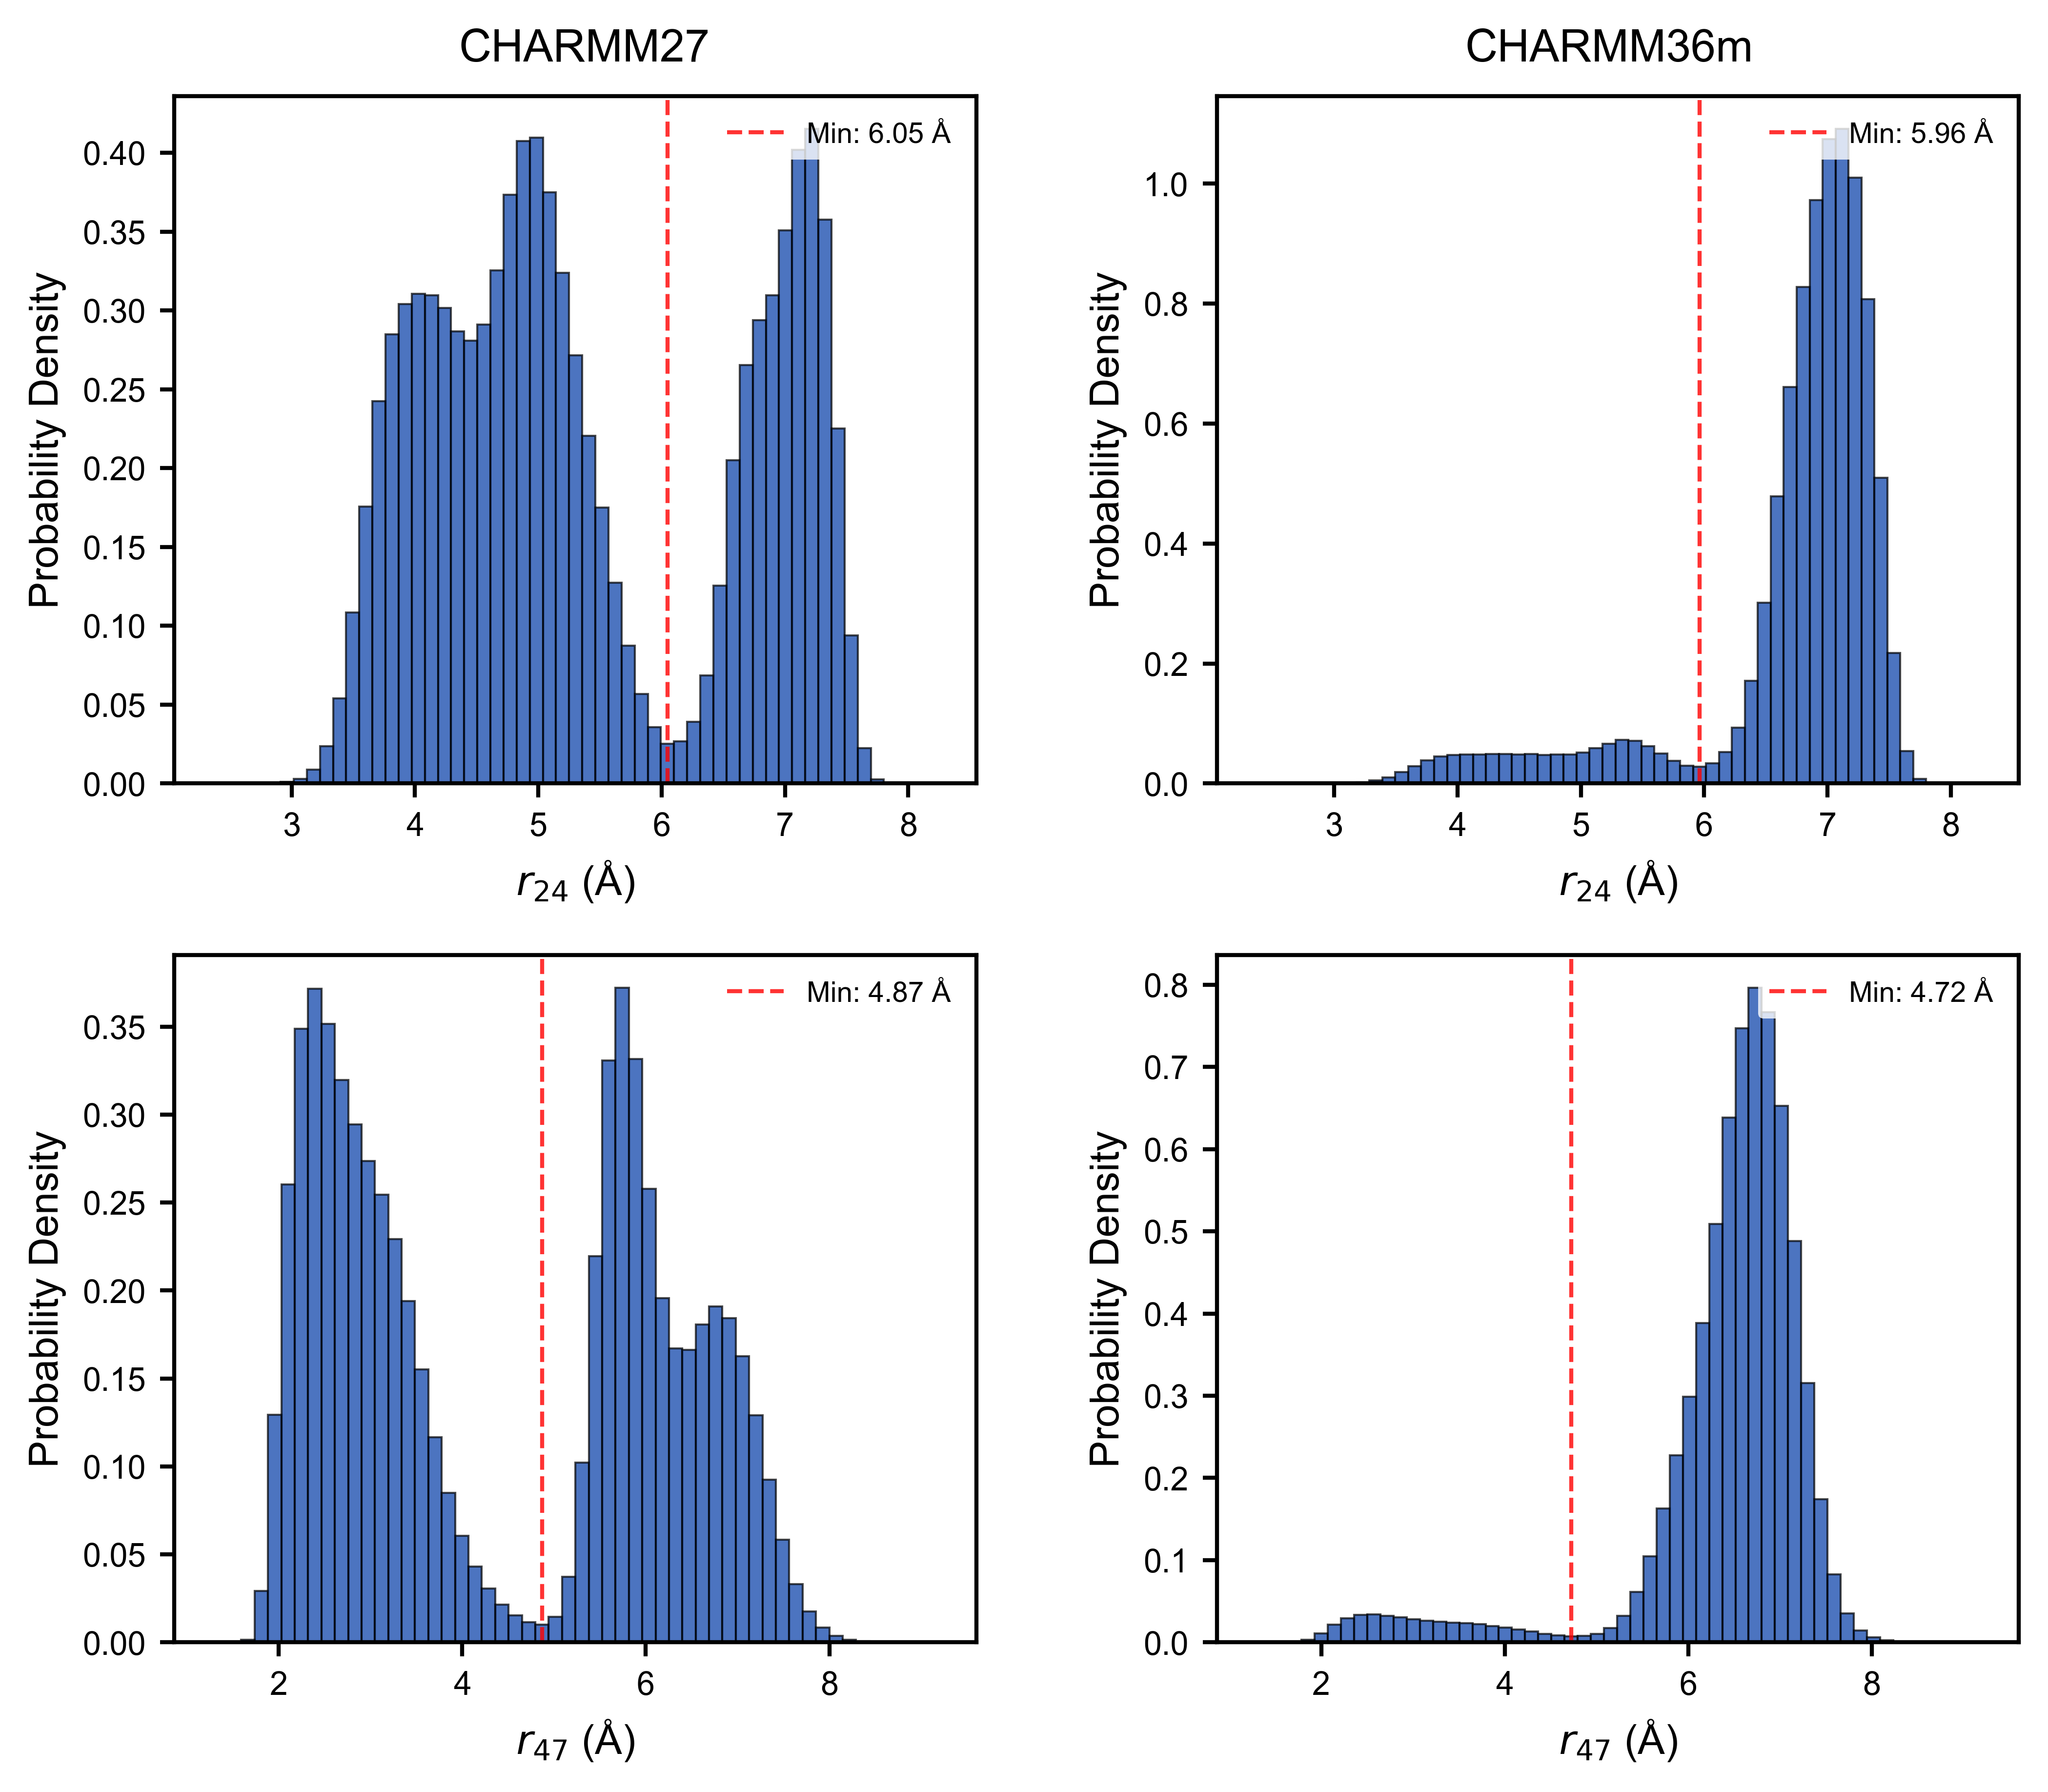


Completed successfully!


In [1]:
### PLOTS PROBABILITY DENSITY HISTOGRAMS FOR 2 MAIN CVs FOR BOTH FFs (FIG S05) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
PROP_ARRAY_DIR = BASE_DIR / 'prop_array'

# Data Specifications
FORCE_FIELDS = ['CHARMM27_TIP3P', 'CHARMM36m_TIP3P']
FORCE_FIELD_LABELS = {'CHARMM27_TIP3P': 'CHARMM27', 'CHARMM36m_TIP3P': 'CHARMM36m'}

# Analysis Parameters
TARGET_FEATURES = {'r24': 0, 'r47': 2}
MINIMA_RANGES = {'r24': (5.0, 7.0), 'r47': (4.0, 6.0)}
NM_TO_ANGSTROM = 10.0
SUBSAMPLE_RATE = 10
N_BINS = 50

# Plotting Specifications
FIGURE_SIZE = (7, 6)
DPI = 600
HIST_ALPHA = 0.7
HIST_COLOR = '#0039A6'
X_PADDING = 0.1

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_cv_array(force_field):
    """Load CV array for specified force field."""
    filepath = PROP_ARRAY_DIR / force_field / f'CV_array_{force_field}.npy'
    
    if not filepath.exists():
        raise FileNotFoundError(f"Missing CV array file: {filepath}")
    
    print(f"Loading {force_field} data from {filepath}")
    raw_data = np.load(filepath)
    
    # Subsample and convert units
    subsampled_data = raw_data[::SUBSAMPLE_RATE]
    converted_data = subsampled_data * NM_TO_ANGSTROM
    
    print(f"  Original shape: {raw_data.shape}")
    print(f"  Subsampled shape: {subsampled_data.shape}")
    print(f"  Converted to Angstroms")
    
    return converted_data

def load_all_data():
    """Load and organize data for all force fields."""
    data_dict = {}
    
    for force_field in FORCE_FIELDS:
        cv_array = load_cv_array(force_field)
        data_dict[force_field] = {
            'r24': extract_feature_column(cv_array, 'r24'),
            'r47': extract_feature_column(cv_array, 'r47')
        }
    
    return data_dict

def extract_feature_column(data_array, feature_key):
    """Extract specific feature column from CV array."""
    column_index = TARGET_FEATURES[feature_key]
    feature_data = data_array[:, column_index]
    print(f"  Extracted {feature_key} (column {column_index}): "
          f"range {feature_data.min():.2f}-{feature_data.max():.2f} Å")
    return feature_data

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def find_histogram_minimum(data, feature_key):
    """Find minimum value in histogram within specified range."""
    histogram, bin_edges = np.histogram(data, bins=N_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Apply range filter
    range_min, range_max = MINIMA_RANGES[feature_key]
    mask = (bin_centers >= range_min) & (bin_centers <= range_max)
    
    if not np.any(mask):
        print(f"  Warning: No data points in range {range_min}-{range_max} for {feature_key}")
        return None
    
    # Find minimum within range
    filtered_centers = bin_centers[mask]
    filtered_histogram = histogram[mask]
    minimum_index = np.argmin(filtered_histogram)
    minimum_value = filtered_centers[minimum_index]
    
    print(f"  Found minimum for {feature_key}: {minimum_value:.2f} Å")
    return minimum_value

def compute_shared_axis_limits(*datasets):
    """Calculate shared axis limits for multiple datasets."""
    global_min = min(data.min() for data in datasets)
    global_max = max(data.max() for data in datasets)
    
    # Add padding
    data_range = global_max - global_min
    padding = X_PADDING * data_range
    
    return global_min - padding, global_max + padding

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def plot_single_histogram(ax, data, feature_key, x_limits, x_label):
    """Plot histogram for single dataset with minimum marker."""
    # Create histogram
    ax.hist(data, bins=N_BINS, alpha=HIST_ALPHA, color=HIST_COLOR,
            density=True, edgecolor='black', linewidth=0.5)
    
    # Find and mark minimum
    minimum_value = find_histogram_minimum(data, feature_key)
    if minimum_value is not None:
        ax.axvline(minimum_value, color='red', linestyle='--', 
                  linewidth=1, alpha=0.8,
                  label=f'Min: {minimum_value:.2f} Å')
        ax.legend(fontsize=7, loc='upper right', frameon=True,
                 facecolor='white', edgecolor='none')
    
    # Format axes
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel('Probability Density', fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.set_xlim(x_limits)

def create_comparison_figure(data_dict):
    """Create 2x2 grid comparing histograms across force fields and features."""
    fig = plt.figure(figsize=FIGURE_SIZE, dpi=DPI)
    
    # Create grid layout
    outer_grid = gridspec.GridSpec(2, 2, figure=fig, 
                                  hspace=0.25, wspace=0.3,
                                  top=0.96, bottom=0.08, 
                                  left=0.08, right=0.98)
    
    # Add column titles
    fig.text(0.28, 0.98, FORCE_FIELD_LABELS['CHARMM27_TIP3P'], 
             fontsize=11, ha='center')
    fig.text(0.78, 0.98, FORCE_FIELD_LABELS['CHARMM36m_TIP3P'], 
             fontsize=11, ha='center')
    
    # Calculate shared axis limits for each feature
    r24_limits = compute_shared_axis_limits(
        data_dict['CHARMM27_TIP3P']['r24'], 
        data_dict['CHARMM36m_TIP3P']['r24']
    )
    r47_limits = compute_shared_axis_limits(
        data_dict['CHARMM27_TIP3P']['r47'], 
        data_dict['CHARMM36m_TIP3P']['r47']
    )
    
    # Define panel specifications
    panel_specs = [
        (0, 0, 'CHARMM27_TIP3P', 'r24', r24_limits, r'$\mathit{r}_{24}$ (Å)'),
        (0, 1, 'CHARMM36m_TIP3P', 'r24', r24_limits, r'$\mathit{r}_{24}$ (Å)'),
        (1, 0, 'CHARMM27_TIP3P', 'r47', r47_limits, r'$\mathit{r}_{47}$ (Å)'),
        (1, 1, 'CHARMM36m_TIP3P', 'r47', r47_limits, r'$\mathit{r}_{47}$ (Å)')
    ]
    
    # Create each panel
    for row, col, force_field, feature, x_limits, x_label in panel_specs:
        ax = fig.add_subplot(outer_grid[row, col])
        plot_single_histogram(ax, data_dict[force_field][feature], 
                            feature, x_limits, x_label)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run H-O-N distance histogram analysis."""
    set_plot_style()
    
    print("=" * 50)
    
    try:
        # Load all data
        print("\nLoading CV arrays...")
        data_dict = load_all_data()
        
        # Create comparison plot
        print("\nCreating plot...")
        fig = create_comparison_figure(data_dict)
        
        # Display results
        plt.show()
        
        print("\nCompleted successfully!")
        print("=" * 50)
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        raise

if __name__ == "__main__":
    main()